In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import arviz as az

In [2]:
from sim.dy.model_intv import ModelIntv
import sim.dy.keys as I

In [3]:
out_path = f'out/dy_ladd'

In [4]:
pars_post = json.load(open(f'{out_path}/Post.json', 'r'))

In [5]:
m = ModelIntv(year0=1970)

In [10]:
p0 = pars_post[0]

y1, p1 = m.find_baseline(p0, 2022)

_, ms0, _ = m.simulate_onward(y1, p1, intv={'FullACF': {'Coverage': 0.4}}, polished=False)

<AxesSubplot:xlabel='Time'>

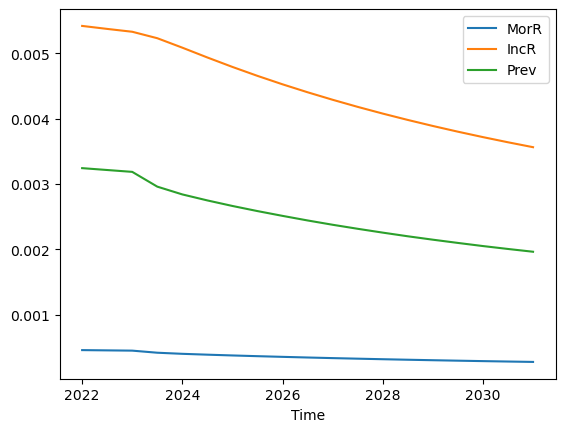

In [11]:
ms0[['MorR', 'IncR', 'Prev']].plot()